In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import math

In [2]:
# create a dataframe containing the successful number of hits, the sample size (n) and an estimator for p 
# where p is an estimate for the probability of hitting a 1 with either an Event RPG or Iron Scimitar
def get_trimmed_df(df, weapon):
    section_length = len(df) // 4
    
    d = {   "Event RPG"   : (0, section_length),
          "Iron Scimitar" : (section_length * 2 + 1, section_length * 3) }
    (a, b) = d[weapon]
    
    trimmed_df = df.iloc[a:b, :].drop("Exp Type", axis = 1)
    
    return trimmed_df

def get_probability_df(df, weapon):
    attack_speed = {   "Event RPG"   : 1.8,  # Event RPG attacks once every 1.8s 
                     "Iron Scimitar" : 2.4 } # Iron Scimitar attacks once every 2.4s
    
    successful_attacks = df.loc[1:, "Exp Gained"].to_numpy() / 4
    total_attacks = df.loc[1:, "Time (min)"].to_numpy() * 60 / attack_speed[weapon]
    total_attacks = [math.floor(attacks) for attacks in total_attacks]
    p = successful_attacks / total_attacks
    
    d = { "Successful Attacks" : successful_attacks,
          "Total Attacks"      : total_attacks,
          "p"                  : p }
    
    probability_df = pd.DataFrame(data = d)
    probability_df["Weapon"] = weapon
    
    return probability_df
    
# get the number of successful hits using weapon for all 10 minute intervals
# based on the cumulative number of hits from df, return in numpy array
def get_interval_hit_data(df, weapon):
    section_length = len(df) // 2
    
    d = {   "Event RPG"   : df.iloc[:section_length, 0],
          "Iron Scimitar" : df.iloc[section_length:, 0] }
    
    preprocessed_kde_data = [0]
    preprocessed_kde_data.extend(d[weapon])
    
    kde_data = [preprocessed_kde_data[i] - preprocessed_kde_data[i - 1] for i in range(len(preprocessed_kde_data))]
    kde_data.pop(0)
    kde_data = np.array(kde_data) # convert to np array
    
    return kde_data

# get the average number of successful hits per minute
def get_mean_hit_rate(interval_hit_data):
    mean = np.mean(interval_hit_data)
    reduced_mean = mean // 10
    
    return reduced_mean

def get_probability_parameters(df, weapon):
    df_length = len(df)
    
    row = {   "Event RPG"   : df_length // 2 - 1,
            "Iron Scimitar" : df_length - 1 }
    
    n, p = df.iloc[row[weapon], 1], round(combined_probability_df.iloc[row[weapon], 2], 6)
    
    return n, p

# displays binomial probability parameters λ, n and p for weapon
def display_parameters(n, p, λ, weapon):
    print("---", weapon, "---")
    print("n:", n)
    print("p:", p)
    print("λ:", λ)
    
# calculate the pooled test statistic for two distributions with sample 
# sizes n1 and n2 along with success probabilities p1 and p2
def get_pooled_test_statistic(n1, n2, p1, p2):
    p = (((n1) * (p1)) + ((n2) * (p2))) / (n1 + n2)
    sigma = math.sqrt(p * (1 - p) * ((1 / n1) + (1 / n2)))
    
    
    z  = (p1 - p2) / sigma if (p1 > p2) else ((p2 - p1) / sigma)
    rounded_z = round(z, 6)
    
    return rounded_z

In [3]:
# load data
combined_df = pd.read_csv("data/combined_data.csv")

In [4]:
# transform data 
trimmed_rpg_df = get_trimmed_df(combined_df, "Event RPG")
trimmed_scim_df = get_trimmed_df(combined_df, "Iron Scimitar")

# calculate and add the probabilities of hitting a 1 to the dataframes
rpg_probability_df = get_probability_df(trimmed_rpg_df, "Event RPG")
scim_probability_df = get_probability_df(trimmed_scim_df, "Iron Scimitar")

# transform data for visualization
combined_probability_df = rpg_probability_df.append(scim_probability_df)

In [5]:
# write processed data to csv
combined_probability_df.to_csv("data/combined_probability_data.csv", index = False)

In [6]:
# load processed data
combined_probability_df = pd.read_csv("data/combined_probability_data.csv")

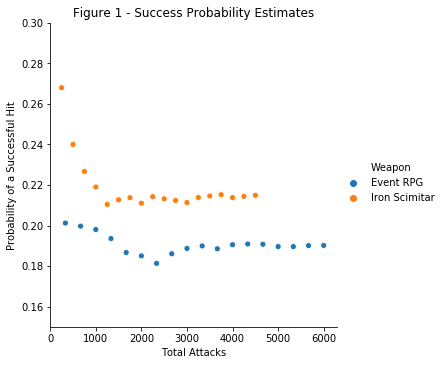

In [7]:
# visualize trend of success probability p as sample size n increases 
successful_hits_scatter = sns.relplot(x = "Total Attacks" ,
                                      y = "p",
                                      hue = "Weapon",
                                      data = combined_probability_df)

successful_hits_scatter.set(title = "Figure 1 - Success Probability Estimates",
                            xlabel = "Total Attacks",
                            ylabel = "Probability of a Successful Hit")
plt.xlim(5, None)
plt.ylim(0.15, 0.3)

plt.show()

In [8]:
# get the number of successful hits for every 10 minute interval
rpg_interval_hit_data = get_interval_hit_data(combined_probability_df, "Event RPG")
scim_interval_hit_data = get_interval_hit_data(combined_probability_df, "Iron Scimitar")

# probability of successful hits for every individual 10 minute interval
rpg_hit_probability_data = rpg_interval_hit_data / 333
scim_hit_probability_data = scim_interval_hit_data / 250

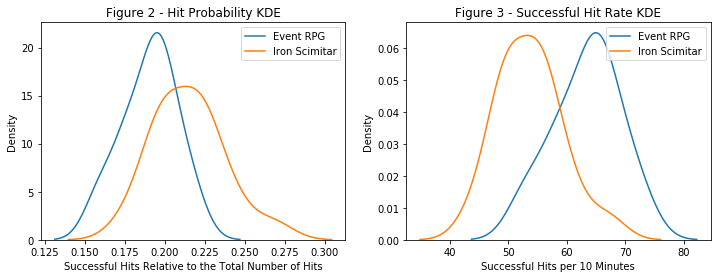

In [9]:
# kde for the number and probability of successful hits per 10 minutes
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (12, 4))

combined_hit_probability_kde = sns.kdeplot(rpg_hit_probability_data, label = "Event RPG", ax = ax1)
combined_hit_probability_kde = sns.kdeplot(scim_hit_probability_data, label = "Iron Scimitar", ax = ax1)

combined_hit_probability_kde.set(title = "Figure 2 - Hit Probability KDE",
                 xlabel = "Successful Hits Relative to the Total Number of Hits",
                 ylabel = "Density")

combined_interval_hit_kde = sns.kdeplot(rpg_interval_hit_data, label = "Event RPG", ax = ax2)
combined_interval_hit_kde = sns.kdeplot(scim_interval_hit_data, label = "Iron Scimitar", ax = ax2)

combined_interval_hit_kde.set(title = "Figure 3 - Successful Hit Rate KDE",
                 xlabel = "Successful Hits per 10 Minutes",
                 ylabel = "Density")

plt.show()

Figure 2 suggests that the Iron Scimitar is more accurate than the Event RPG while Figure 3 suggests that training with the Event RPG typically results in more successful hits every 10 minutes. This implies that attack speed results in higher experience rates when compared to attack bonuses.
<br>

Having observed differences between the Event RPG and Iron Scimitar in both the linear regression and the kernel density estimates I now set out to determine whether or not the difference is statistically significant through hypothesis testing.

In [10]:
# get and display the mean number of successful attacks per minute (λ), the total number of attacks (n) 
# along with success probability estimate (p) for the Event RPG
rpg_λ = get_mean_hit_rate(rpg_interval_hit_data)

rpg_probability_parameters = get_probability_parameters(combined_probability_df, "Event RPG")
rpg_n, rpg_p = rpg_probability_parameters[0], rpg_probability_parameters[1]

display_parameters(rpg_n, rpg_p, rpg_λ, "Event RPG")

--- Event RPG ---
n: 6000
p: 0.190167
λ: 6.0


In [11]:
scim_λ = get_mean_hit_rate(scim_interval_hit_data)

scim_probability_parameters = get_probability_parameters(combined_probability_df, "Iron Scimitar")
scim_n, scim_p = scim_probability_parameters[0], scim_probability_parameters[1]

display_parameters(scim_n, scim_p, scim_λ, "Iron Scimitar")

--- Iron Scimitar ---
n: 4500
p: 0.214889
λ: 5.0


Having obtained the parameters for the Event RPG and Iron Scimitar, I proceed to use the p's to construct binomial distributions and formulate hypotheses regarding whether or not attack bonuses affect the probability of a successful hit.

<br>

<center>
Letting $R_{b}$ and $S_{b}$ denote the number of successful hits per minute using the Event RPG and Iron Scimitar respectively,
</center>

<center> 
    <i> $R_{b}$ ~ binomial ( $n_{1}$, $p_{1}$) </i> and <i> $S_{b}$ ~ binomial ( $n_{2}$, $p_{2}$) </i> 
    where $p_{1}$ = 0.190167 and $p_{2}$ = 0.214889
</center>
<br>

<center>
    Hypotheses:
    <br>
    $H_{0}$: $p_{1}$ = $p_{2}$
    <br>
    $H_{1}$: $p_{1}$ ≠ $p_{2}$
</center>

<br>
Using a significance level of 0.05, I will reject the null hypothesis if the test statistic falls in the rejection region or, in other words, if there is less than a 5% chance of observing similar results. In terms of pooled test statistic $z_{t}$, the two statements can be expressed as $z_{t} > 1.96$ and $2P(Z > z_{t}) < 0.05$.


In [15]:
z_test = get_pooled_test_statistic(rpg_n, scim_n, rpg_p, scim_p)
print("test statistic =", z_test)

test statistic = 3.129622




<center> 
    <i> $R_{p}$ ~ Poisson ( $λ_{1}$) </i> and <i> $S_{p}$ ~ Poisson ( $λ_{2}$) </i> 
    where $λ_{1}$ = 6 and $λ_{2}$ = 5
</center>
<br>
<center>
    Hypotheses:
    <br>
    $H_{0}$: $λ_{1}$ <u> <</u> $λ_{2}$
    <br>
    $H_{1}$: $λ_{1}$ > $λ_{2}$
</center>